# Get env info

In [1]:
import os
is_env_colab = True

if "kaggle" in os.path.abspath("."):
    is_env_colab = False

# Prepare for colab

In [ ]:
if is_env_colab:
    !pip install catboost

# Kaggle Set up

In [ ]:
if is_env_colab:
    !pip install kaggle

## Upload API Token

In [ ]:
if is_env_colab:
    from google.colab import files

    uploaded = files.upload()

    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))

    # Then move kaggle.json into the folder where the API expects to find it.
    !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

## Download and unzip dataset

In [ ]:
if is_env_colab:
    !kaggle datasets download -d huseyincot/amex-agg-data-pickle
    !unzip /content/amex-agg-data-pickle.zip

In [ ]:
if is_env_colab:
    !kaggle competitions download -c amex-default-prediction -f sample_submission.csv
    !unzip /content/sample_submission.csv.zip

# Settings

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import os
import gc; gc.enable()

import warnings
warnings.filterwarnings('ignore')

In [3]:
VER=1
SEED = 22
FOLDS = 5

cat_features = ["B_30", "B_38", "D_114", "D_116", "D_117", "D_120", "D_126", "D_63", "D_64", "D_66", "D_68"]

In [4]:
parent_dir = "../input/"
if is_env_colab:
    parent_dir = "/content/"    

In [ ]:
# train = pd.read_pickle(parent_dir + "amexdefaultpickleincludemedian/train_agg.pkl", compression="gzip")
# train = train.reset_index(level=0)

# test = pd.read_pickle(parent_dir + "amexdefaultpickleincludemedian/test.pkl", compression="gzip")
# test = test.reset_index(level=0)

train = pd.read_pickle(parent_dir + "amex-agg-data-pickle/train_agg.pkl", compression="gzip")
test = pd.read_pickle(parent_dir + "amex-agg-data-pickle/test_agg.pkl", compression="gzip")

In [ ]:
cat_features_last = [f"{cf}_last" for cf in cat_features]

le_encoder = LabelEncoder()
for categorical_feature in cat_features_last:
    train[categorical_feature] = le_encoder.fit_transform(train[categorical_feature])
    test[categorical_feature] = le_encoder.transform(test[categorical_feature])

In [ ]:
# https://www.kaggle.com/code/ragnar123/amex-lgbm-dart-cv-0-7963
# Round last float features to 2 decimal place
float_cols = list(train.dtypes[(train.dtypes == 'float16') | (train.dtypes == 'float32') | (train.dtypes == 'float64')].index)
float_cols = [col for col in float_cols if 'last' in col]

train[float_cols] = train[float_cols].round(3)
test[float_cols] = test[float_cols].round(3)

In [ ]:
# train = train.set_index('customer_ID')
train = train.sort_index().reset_index()
FEATURES = train.drop(columns=['customer_ID', 'target']).columns

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train.target), y=train.target)
class_weights

In [ ]:
# https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
# https://www.kaggle.com/code/rohanrao/amex-competition-metric-implementations
def amex_metric_np(target: np.ndarray, preds: np.ndarray) -> float:
    indices = np.argsort(preds)[::-1]
    preds, target = preds[indices], target[indices]

    n_pos = np.sum(target)
    n_neg = target.shape[0] - n_pos
    
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight * (1 / weight.sum())).cumsum()
    four_pct_mask = cum_norm_weight <= 0.04
    d = np.sum(target[four_pct_mask]) / n_pos
    
    lorentz = (target * (1 / n_pos)).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    g = gini / gini_max

    return 0.5 * (g + d)

class CustomMetric(object):
   def get_final_error(self, error, weight): return error
   def is_max_optimal(self): return True
   def evaluate(self, approxes, target, weight): return amex_metric_np(np.array(target), approxes[0]), 1.0

In [ ]:
cat_params = {
    'iterations':20000,
    'random_state':SEED,
    'learning_rate':0.025,
    'one_hot_max_size':20,
    
#     'depth': 4,
    'l2_leaf_reg': 14.0,
#     'eval_metric': CustomMetric(),
#     'random_strength': 0.5,
#     'bagging_temperature': 0.99,
#     'class_weights':class_weights,

    'task_type':"GPU",
    'border_count':128,
}

In [ ]:
importances = []
oof = []
gc.collect()

clf = CatBoostClassifier(**cat_params)
skf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)
for fold,(train_idx, valid_idx) in enumerate(skf.split(train, train.target)):
    
    print('#'*25)
    print('### Fold',fold+1)
    print('### Train size',len(train_idx),'Valid size',len(valid_idx))
    print(f'### Training with 100% fold data...')
    print('#'*25)
    
    # TRAIN, VALID, TEST FOR FOLD K
    X_train = train.loc[train_idx, FEATURES]
    X_valid = train.target.iloc[train_idx]
    y_train = train.loc[valid_idx, FEATURES]
    y_valid = train.target.iloc[valid_idx]
    
    # TRAIN MODEL FOLD K
    model = clf.fit(X_train,
                    X_valid,
                    cat_features=cat_features_last,
                    eval_set=[(y_train, y_valid)],
                    use_best_model=True,
                    early_stopping_rounds=300,
                    verbose_eval=500)
    model.save_model(f'CAT_v{VER}_fold{fold}.cbm')
    
    # GET FEATURE IMPORTANCE FOR FOLD K
    dd = model.feature_importances_
    df = pd.DataFrame({'feature':FEATURES,f'importance_{fold}':dd})
    importances.append(df)
            
    # INFER OOF FOLD K
    oof_preds = model.predict_proba(y_train)[:, 1]
    acc = amex_metric_np(y_valid.values, oof_preds)
    print('Amex Metric =',acc,'\n')

    df = train.loc[valid_idx, ['customer_ID','target'] ].copy()
    df['oof_preds'] = oof_preds
    oof.append(df)
    
    del X_train, y_train, dd, df
    del X_valid, y_valid, model
    _ = gc.collect()
    
print('#'*25)
oof = pd.concat(oof,axis=0,ignore_index=True).set_index('customer_ID')
acc = amex_metric_np(oof.target.values, oof.oof_preds.values)
print(f"Overall Amex metric: {acc}")

In [ ]:
# CLEAN RAM
del train
_ = gc.collect()

In [ ]:
df = importances[0].copy()
for k in range(1,FOLDS): df = df.merge(importances[k], on='feature', how='left')
df['importance'] = df.iloc[:,1:].mean(axis=1, numeric_only=True)
df = df.sort_values('importance',ascending=False)
df.to_csv(f'cat_feature_importance_v{VER}.csv',index=False)

In [ ]:
NUM_FEATURES = 20
plt.figure(figsize=(10,5*NUM_FEATURES//10))
plt.barh(np.arange(NUM_FEATURES,0,-1), df.importance.values[:NUM_FEATURES])
plt.yticks(np.arange(NUM_FEATURES,0,-1), df.feature.values[:NUM_FEATURES])
plt.title(f'CAT Feature Importance - Top {NUM_FEATURES}')
plt.show()

# Test part

In [ ]:
# CALCULATE SIZE OF EACH SEPARATE TEST PART
def get_rows(customers, test, NUM_PARTS = 4, verbose = ''):
    chunk = len(customers)//NUM_PARTS
    if verbose != '':
        print(f'We will process {verbose} data as {NUM_PARTS} separate parts.')
        print(f'There will be {chunk} customers in each part (except the last part).')
        print('Below are number of rows in each part:')
    rows = []

    for k in range(NUM_PARTS):
        if k==NUM_PARTS-1: cc = customers[k*chunk:]
        else: cc = customers[k*chunk:(k+1)*chunk]
        s = test.loc[test.customer_ID.isin(cc)].shape[0]
        rows.append(s)
    if verbose != '': print( rows )
    return rows,chunk

In [ ]:
# COMPUTE SIZE OF 4 PARTS FOR TEST DATA
NUM_PARTS = 4
test = test.sort_index().reset_index()
customers = test[['customer_ID']].drop_duplicates().sort_index().values.flatten()
rows,num_cust = get_rows(customers, test[['customer_ID']], NUM_PARTS = NUM_PARTS, verbose = 'test')

In [ ]:
# INFER TEST DATA IN PARTS
skip_rows = 0
skip_cust = 0
test_preds = []

for k in range(NUM_PARTS):
    
    # READ PART OF TEST DATA
    print(f'\nReading test data...')
    test_copy = test.iloc[skip_rows:skip_rows+rows[k]].copy()
    test_copy = test_copy.set_index('customer_ID')
    skip_rows += rows[k]
    print(f'=> Test part {k+1} has shape', test_copy.shape )
    
    # PROCESS AND FEATURE ENGINEER PART OF TEST DATA
    if k==NUM_PARTS-1: test_copy = test_copy.loc[customers[skip_cust:]]
    else: test_copy = test_copy.loc[customers[skip_cust:skip_cust+num_cust]]
    skip_cust += num_cust
        
    # INFER XGB MODELS ON TEST DATA
    model = CatBoostClassifier(**cat_params)
    model.load_model(f'CAT_v{VER}_fold0.cbm')
    preds = model.predict_proba(test_copy)[:, 1]
    for f in range(1,FOLDS):
        model.load_model(f'CAT_v{VER}_fold{f}.cbm')
        preds += model.predict_proba(test_copy)[:, 1]
    preds /= FOLDS
    test_preds.append(preds)

    # CLEAN MEMORY
    del test_copy, model
    _ = gc.collect()

del test
_ = gc.collect()

# Submit

In [ ]:
# WRITE SUBMISSION FILE
test_preds = np.concatenate(test_preds)
test = pd.DataFrame(index=customers,data={'prediction':test_preds})
sub = pd.read_csv(parent_dir + 'amex-default-prediction/sample_submission.csv')[['customer_ID']]
sub['customer_ID_hash'] = sub['customer_ID'].copy()
sub = sub.set_index('customer_ID_hash')
sub = sub.merge(test[['prediction']], left_index=True, right_index=True, how='left')
sub = sub.reset_index(drop=True)

# DISPLAY PREDICTIONS
sub.to_csv(f'submission_cat_v{VER}.csv',index=False)
print('Submission file shape is', sub.shape )
sub.head()

In [ ]:
# PLOT PREDICTIONS
plt.hist(sub.prediction, bins=100)
plt.title('Test Predictions')
plt.show()

# Ensemble

## Do only ensemble

In [5]:
sub = pd.read_csv(parent_dir + 'amex-default-prediction/sample_submission.csv')

In [6]:
# https://www.kaggle.com/code/beezus666/ensemble-weighted-average
#crude formula for model weighting.
# Using this formaula the best model's weight = 1, the worst model's weight ~0.05
def model_weight(model_loss, worst_loss, best_loss):
    return 1- ((best_loss - model_loss)/(best_loss-(worst_loss - 0.01)))

def read_weighted_preds(sub_dict: dict, worst_score:float, best_score: float) -> list:
    preds = []
    weights = []
    for path, loss in sub_dict.items():
        weight = model_weight(loss, worst_score, best_score)
        
        df = pd.read_csv(path)
        df = df.set_index('customer_ID').sort_index().reset_index() # sort
        df['prediction'] = df['prediction']*weight
        
        preds.append(df['prediction'])
        weights.append(weight)
    
    return preds, weights

In [11]:
best = 0.796
worst = 0.789

sub_dict = {
    parent_dir + 'amexdefaultsubmissions/submission_cat_v26_0794.csv': 0.794,
    parent_dir + 'amexdefaultsubmissions/submission_TF_GRU0789.csv': 0.789,
#     parent_dir + 'amexdefaultsubmissions/submission_xgb_v24.csv': 0.794,
    parent_dir + 'amexdefaultsubmissions/test_lgbm_baseline_5fold_seed42.csv': 0.796,
#     parent_dir + 'amexdefaultsubmissions/submission_cat_0.7923765971248049.csv': 0.7923765971248049,
    parent_dir + 'amexdefaultsubmissions/submission_tabnet0791.csv': 0.791,
    parent_dir + 'amexdefaultsubmissions/lightautoml_tabularautoml0795.csv': 0.795,
    parent_dir + 'amexdefaultsubmissions/submission_xgb_nvt_0._794csv.csv': 0.794,
#     parent_dir + 'amexdefaultsubmissions/submission_CosSquareFormer_0788.csv': 0.788,
#     '../input/amex-keras-quickstart-1-training/submission.csv': 0.79,
#     '../input/tensorflow-transformer-0-790/submission.csv': 0.79,
}

preds, weights = read_weighted_preds(sub_dict, worst, best)

In [12]:
blend_ss = sub.copy()
blend_ss['prediction'] = np.sum(np.column_stack(preds), axis=1) / sum(weights)
# blend_ss['prediction'] = (np.mean(np.column_stack(preds), axis=1))
blend_ss.to_csv('submission_blend.csv', index=False)
blend_ss

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.026525
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.001221
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.047464
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.249068
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.858035
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.013613
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.790914
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.466694
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.289450


In [9]:
blend_ss.describe()

,prediction
count,924621.000000
mean,0.247392
std,0.342663
min,0.000160
25%,0.003055
50%,0.026600
75%,0.479761
max,0.989852


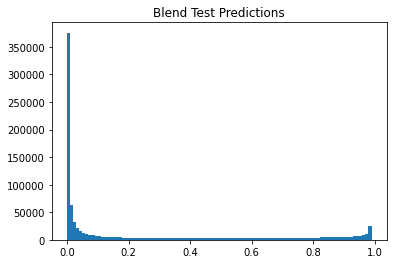

In [10]:
# PLOT PREDICTIONS
plt.hist(blend_ss.prediction, bins=100)
plt.title('Blend Test Predictions')
plt.show()

# Submit to Kaggle from Colab

In [ ]:
# Submit
if is_env_colab:
    # !kaggle competitions submit -c amex-default-prediction -f submission_cat_v1.csv -m "From colab"
    !kaggle competitions submit -c amex-default-prediction -f submission_blend.csv -m "From colab"

In [ ]:
# Run after few seconds
!kaggle competitions submissions amex-default-prediction